In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import cvxpy as cp

# Generate synthetic dataset

In [2]:
def new_dataset(n, k, T):
    
    Hs, Ys, As, Bs = [], [], [], []
    
    for t in range(1, T + 1):
        
        # Compute H's
        h = np.random.uniform(-1.0, 1.0, (k,n))
        Hs.append(h)

        # Compute Y's
        y = h @ np.ones((n,1))
        epsilon = stats.truncnorm(-1., 1.).rvs(k).reshape(-1,1)
        y = y + epsilon
        Ys.append(y)

        # Compute A's
        a = np.random.uniform(0.0, 2.0, (k,n))
        As.append(a)

        # Compute B's
        b = np.random.uniform(0.0, 1.0, (k,1))
        Bs.append(b)
    
    return Hs, Ys, As, Bs

# Algorithms

## Follow-the-Regularized-Leader

In [3]:
class adv_FTRL:
    
    def __init__(self, x_0, T, assumptions_param):
        
        self.x_0 = x_0        # Initial guess
        self.n = x_0.shape[0] # Optmization variable in R^n
        
        # Assumptions parameters:
        # F denotes the Lipschitz constant of the cost functions
        # G denotes the Lipschitz constant of the constraint functions
        # D denotes the diameter of the static domain set
        self.F, self.G, self.D = assumptions_param
        
        # Algorithm parameters
        self.V = T**(3/4)
        self.beta = T**(1/4)
        self.rho = 2 * np.sqrt(self.F * self.D * T * (self.V / self.beta))
        self.eta = 1 / (32 * self.beta**2 * self.G**2 * T)
        
        self.Q = 0.0
        self.P = max(self.rho, self.Q)
    
    
    def _R(self, x):
        # Twice-differentiable, smooth, strongly-convex regularization function
        return cp.norm(x - self.x_0)**2
    
    
    def _Phi_grad(self, x):
        # Derivative of the non-decreasing convex Lyapunov function $\Phi(x) = x^2$
        return 2 * x
    
    
    def _solve_opt_prob(self, x, cost, constraints):
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver='SCS')
        
        return x.value.copy()
    
    
    def regret_bound(self, t):
        return (self.F**2 / (8 * self.G**2) + 32 * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def ccv_bound(self, t):
        return (self.F / (np.sqrt(2) * self.G) + np.sqrt(128) * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def run(self, dataset):
        
        # Start with initial guess
        x_pred = self.x_0.copy()
        
        # Save predictions and gradients
        Preds = [x_pred]
        f_t_grads = np.zeros(x_pred.shape)
        
        # Obtain data
        Hs, Ys, As, Bs = dataset
        
        for i in range(T):
            
            # Observe f_t and g_t
            H, y, a, b = Hs[i], Ys[i], As[i], Bs[i]
            f_t = 1/2 * np.linalg.norm(H @ x_pred - y)**2
            g_t = a @ x_pred - b
            g_t_idx = np.argmax(g_t)
            g_t = max(g_t[g_t_idx], 0.0)
            
            # Update CCV
            self.Q = self.Q + g_t
            P = max(self.rho, self.Q)
            
            # Construct gradient of surrogate function
            g_grad = np.zeros((a.shape[1],1))
            if g_t > 0.0:
                g_grad = a[g_t_idx].reshape(-1,1)
            f_grad = (H @ x_pred - y).T @ H
            f_grad = f_grad.reshape(-1,1)

            f_hat_t_grad = self.V * self.beta * f_grad + self._Phi_grad(self.beta * self.P) * self.beta * g_grad
            
            # Follow-the-Regularized-Leader step
            
            ## Construct optimization problem
            x = cp.Variable((n,1)) # Optimization problem
            f_t_grads += f_hat_t_grad
            cost = self.eta * (f_t_grads.T @ x) + self._R(x)

            one_vec = np.ones((n,1))
            constraints = []
            constraints.append(x >= 0)
            constraints.append(x <= 1)
            
            ## Solve optimization problem
            x_pred = self._solve_opt_prob(x, cost, constraints)
            
            ## Save decision
            Preds.append(x_pred)
        
        # Return last decision and set of decisions
        return x_pred, Preds

## AdaGrad

In [4]:
class adv_AdaGrad:
    
    def __init__(self, x_0, T, assumptions_param):
        
        self.x_0 = x_0        # Initial guess
        self.n = x_0.shape[0] # Optmization variable in R^n
        
        # Assumptions parameters:
        # F denotes the Lipschitz constant of the cost functions
        # G denotes the Lipschitz constant of the constraint functions
        # D denotes the diameter of the static domain set
        self.F, self.G, self.D = assumptions_param
        
        # Algorithm parameters
        self.V = 1
        self.G_temp = max(self.F, self.G)
        self.alpha = 1 / (2 * self.G_temp * self.D)
        self.lameda = 1 / (2 * np.sqrt(T))
        
        self.Q = 0.0
    
    
    def _Phi_grad(self, x):
        # Derivative of the non-decreasing convex Lyapunov function $\Phi(x) = x^2$
        return self.lameda * np.exp(self.lameda * x)
    
    
    def regret_bound(self, t):
        return 2 * self.G_temp * self.D * (np.sqrt(t) + 1)
    
    
    def ccv_bound(self, t):
        return 6.6 * self.G_temp * self.D * (2 + np.log(t)) * np.sqrt(t)
    
    
    def run(self, dataset):
        
        # Start with initial guess
        x_pred = self.x_0.copy()
        
        # Save predictions and gradients
        Preds = [x_pred]
        f_t_grads = np.zeros(x_pred.shape)
        f_t_grads_norms = 0.0
        
        # Obtain data
        Hs, Ys, As, Bs = dataset
        
        for i in range(T):
            
            # Observe f_t and g_t
            H, y, a, b = Hs[i], Ys[i], As[i], Bs[i]
            f_t = 1/2 * np.linalg.norm(H @ x_pred - y)**2
            g_t = a @ x_pred - b
            g_t_idx = np.argmax(g_t)
            g_t = max(g_t[g_t_idx], 0.0)
            
            # Update CCV
            self.Q = self.Q + self.alpha * g_t
            
            # Construct gradient of surrogate function
            g_grad = np.zeros((a.shape[1],1))
            if g_t > 0.0:
                g_grad = a[g_t_idx].reshape(-1,1)
            f_grad = (H @ x_pred - y).T @ H
            f_grad = f_grad.reshape(-1,1)
        
            g_grad, f_grad = self.alpha * g_grad, self.alpha * f_grad

            f_hat_t_grad = self.V * f_grad + self._Phi_grad(self.Q) * g_grad
            f_t_grads_norms += np.linalg.norm(f_hat_t_grad)**2
            
            # AdaGrad step
            
            ## Update and project
            eta_t = (np.sqrt(2) * D) / (2 * np.sqrt(f_t_grads_norms))
        
            x_pred = x_pred - eta_t * f_hat_t_grad

            for k in range(x_pred.shape[0]):
                x_pred[k,0] = max(0.0, x_pred[k,0])
                x_pred[k,0] = min(1.0, x_pred[k,0])
            
            ## Save decision
            Preds.append(x_pred)
        
        # Return last decision and set of decisions
        return x_pred, Preds

## Online Gradient Descent

In [5]:
class adv_OGD:
    
    def __init__(self, x_0, T, assumptions_param):
        
        self.x_0 = x_0        # Initial guess
        self.n = x_0.shape[0] # Optmization variable in R^n
        
        # Assumptions parameters:
        # F denotes the Lipschitz constant of the cost functions
        # G denotes the Lipschitz constant of the constraint functions
        # D denotes the diameter of the static domain set
        self.F, self.G, self.D = assumptions_param
        
        # Algorithm parameters
        self.V = T**(3/4)
        self.beta = T**(1/4)
        self.rho = 2 * np.sqrt(self.F * self.D * T * (self.V / self.beta))
        self.eta = 1 / (32 * self.beta**2 * self.G**2 * T)
        
        self.Q = 0.0
        self.P = max(self.rho, self.Q)
    
    
    def _R(self, x):
        # Twice-differentiable, smooth, strongly-convex regularization function
        return cp.norm(x - self.x_0)**2
    
    
    def _Phi_grad(self, x):
        # Derivative of the non-decreasing convex Lyapunov function $\Phi(x) = x^2$
        return 2 * x
    
    
    def regret_bound(self, t):
        return (self.F**2 / (8 * self.G**2) + 4 * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def ccv_bound(self, t):
        return (self.F / (np.sqrt(2) * self.G) + 4 * self.D**2 * self.G**2) * np.sqrt(t)
    
    
    def run(self, dataset):
        
        # Start with initial guess
        x_pred = self.x_0.copy()
        
        # Save predictions and gradients
        Preds = [x_pred]
        f_t_grads = np.zeros(x_pred.shape)
        
        # Obtain data
        Hs, Ys, As, Bs = dataset
        
        for i in range(T):
            
            # Observe f_t and g_t
            H, y, a, b = Hs[i], Ys[i], As[i], Bs[i]
            f_t = 1/2 * np.linalg.norm(H @ x_pred - y)**2
            g_t = a @ x_pred - b
            g_t_idx = np.argmax(g_t)
            g_t = max(g_t[g_t_idx], 0.0)
            
            # Update CCV
            self.Q = self.Q + g_t
            P = max(self.rho, self.Q)
            
            # Construct gradient of surrogate function
            g_grad = np.zeros((a.shape[1],1))
            if g_t > 0.0:
                g_grad = a[g_t_idx].reshape(-1,1)
            f_grad = (H @ x_pred - y).T @ H
            f_grad = f_grad.reshape(-1,1)

            f_hat_t_grad = self.V * self.beta * f_grad + self._Phi_grad(self.beta * self.P) * self.beta * g_grad
            
            # Online Gradient Descent step
            ## Update and project
            
            x_pred = x_pred - self.eta * f_hat_t_grad

            for k in range(x_pred.shape[0]):
                x_pred[k,0] = max(0.0, x_pred[k,0])
                x_pred[k,0] = min(1.0, x_pred[k,0])

            Preds.append(x_pred)
        
        # Return last decision and set of decisions
        return x_pred, Preds

# Run Single Experiment

In [6]:
def compute_cost_and_ccv(dataset, Preds):
    Cost_sum = 0.0
    Cost_arr = []
    CCV_sum = 0.0
    CCV_arr = [0.0]

    # Obtain data
    Hs, Ys, As, Bs = dataset

    for i in range(T):
        H, y, a, b = Hs[i], Ys[i], As[i], Bs[i]
        #val = 1/2 * (np.linalg.norm(H @ Preds[i] - y)**2 - np.linalg.norm(H @ x_star - y)**2)
        Cost_sum += 1/2 * np.linalg.norm(H @ Preds[i] - y)**2
        Cost_arr.append(Cost_sum)

        g_t = a @ Preds[i] - b
        g_t = max(g_t)
        CCV_sum += max(g_t[0], 0.0)
        CCV_arr.append(CCV_sum)
    
    return Cost_arr, CCV_arr

In [7]:
n = 10
k = 4
T = 20000

# Assumptions parameters
D = np.sqrt(2)
F = n**2
G = np.sqrt(4 * n)

# Generate dataset
dataset = new_dataset(n, k, T)

# FTRL

In [8]:
assumptions_param = (F, G, D)

#Initial guess
x_0 = np.random.uniform(0.0, 1.0, size=n).reshape(-1,1)
#x_0[0][0] = 1


FTRL_alg = adv_FTRL(x_0, T, assumptions_param)
_, Preds = FTRL_alg.run(dataset)

In [9]:
Preds_dict = {}
Preds_dict["FTRL"] = Preds

In [10]:
# Compute regret and CCV
Cost_ftrl, CCV_ftrl = compute_cost_and_ccv(dataset, Preds)

In [11]:
def plot_regret(regrets, labels):
    
    # Plot list of regrets
    if len(regrets) != len(labels):
        raise Exception("Length of regrets must be the same as labels")
    
    ts = np.linspace(1,T,T)
    for i in range(len(regrets)):
        plt.plot(ts, regrets[i], label = labels[i], alpha=0.5)
    
    plt.ylabel('Cumulative loss')
    plt.xlabel('$t$ (iterations)')
    plt.yscale('symlog')
    plt.legend()
    

def plot_ccv(ccvs, labels):
    # Plot list of CCV
    if len(ccvs) != len(labels):
        raise Exception("Length of ccvs must be the same as labels")
    
    ts = np.linspace(0,T,T+1)
    for i in range(len(ccvs)):
        plt.plot(ts, ccvs[i], label = labels[i])
    
    plt.ylabel('$CCV(t)$')
    plt.xlabel('$t$ (iterations)')
    plt.yscale('symlog')
    plt.legend()

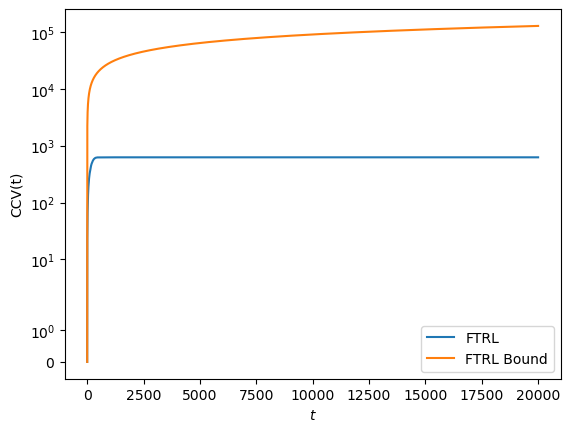

In [12]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, CCV_ftrl, label='FTRL')

plt.plot(ts, FTRL_alg.ccv_bound(ts), label='FTRL Bound')
plt.ylabel('CCV(t)')
plt.xlabel('$t$')
plt.yscale('symlog')
plt.legend()

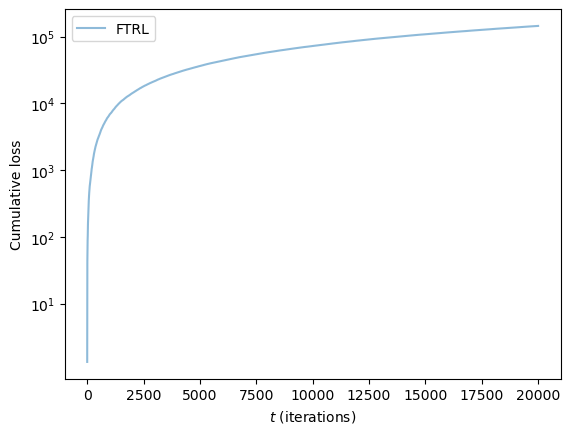

In [13]:
# Plot obtained cost at each round
plot_regret([Cost_ftrl], ['FTRL'])

# AdaGrad

In [14]:
#x_0 = np.random.uniform(0.0, 1.0, size=n).reshape(-1,1)

AdaGrad_alg = adv_AdaGrad(x_0, T, assumptions_param)
_, Preds = AdaGrad_alg.run(dataset)

In [15]:
Preds_dict["AdaGrad"] = Preds

In [16]:
def regret_bound_adagrad(t):
    G_temp = max(F,G)
    return 2 * G_temp * D * (np.sqrt(t) + 1)

def ccv_bound_adagrad(t):
    G_temp = max(F,G)
    return 6.6 * G_temp * D * (2 + np.log(t)) * np.sqrt(t)

In [17]:
# Compute regret and CCV
Cost_AdaGrad, CCV_AdaGrad = compute_cost_and_ccv(dataset, Preds)

/var/folders/bl/yrldgwgd3r3f1mq3t66c5glr0000gn/T/ipykernel_43235/2018462527.py:33: RuntimeWarning: divide by zero encountered in log
  return 6.6 * self.G_temp * self.D * (2 + np.log(t)) * np.sqrt(t)
/var/folders/bl/yrldgwgd3r3f1mq3t66c5glr0000gn/T/ipykernel_43235/2018462527.py:33: RuntimeWarning: invalid value encountered in multiply
  return 6.6 * self.G_temp * self.D * (2 + np.log(t)) * np.sqrt(t)


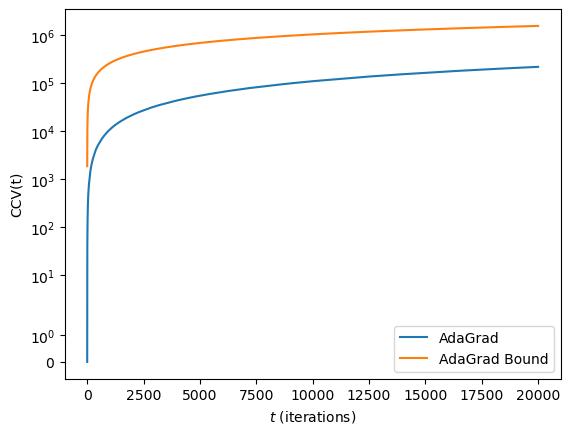

In [18]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, CCV_AdaGrad, label='AdaGrad')

plt.plot(ts, AdaGrad_alg.ccv_bound(ts), label='AdaGrad Bound')
plt.ylabel('CCV(t)')
plt.xlabel('$t$ (iterations)')
plt.yscale('symlog')
plt.legend()

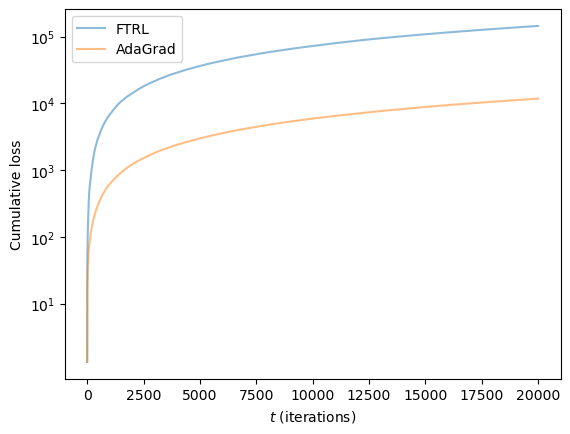

In [19]:
# Plot obtained cost at each round
plot_regret([Cost_ftrl, Cost_AdaGrad], 
            ['FTRL', 'AdaGrad'])

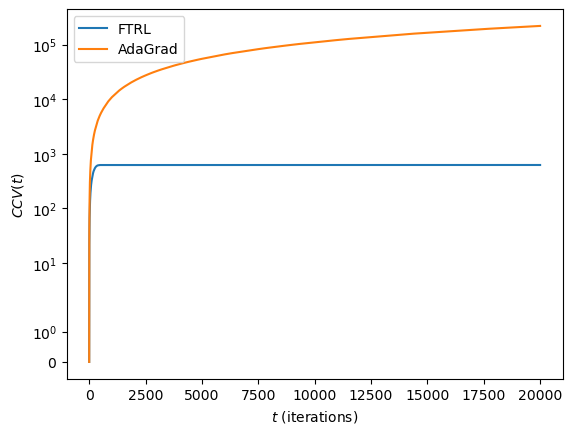

In [20]:
# Plot obtained CCV
plot_ccv([CCV_ftrl, CCV_AdaGrad], 
         ['FTRL', 'AdaGrad'])

# OGD

In [21]:
#x_0 = np.random.uniform(0.0, 1.0, size=n).reshape(-1,1)

ODG_alg = adv_OGD(x_0, T, assumptions_param)
_, Preds = ODG_alg.run(dataset)

In [22]:
Preds_dict["OGD"] = Preds

In [23]:
# Compute regret and CCV
Cost_ogd, CCV_ogd = compute_cost_and_ccv(dataset, Preds)

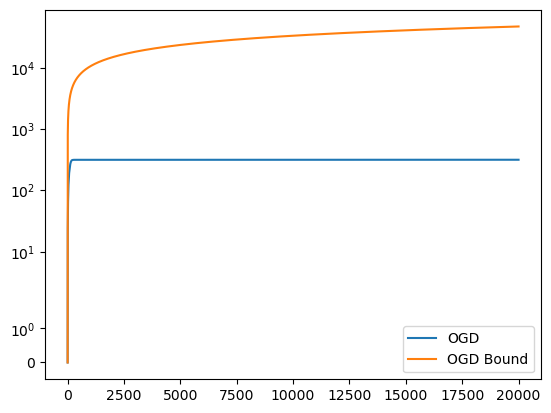

In [24]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, CCV_ogd, label='OGD')

plt.plot(ts, ODG_alg.ccv_bound(ts), label='OGD Bound')
plt.yscale('symlog')
plt.legend()

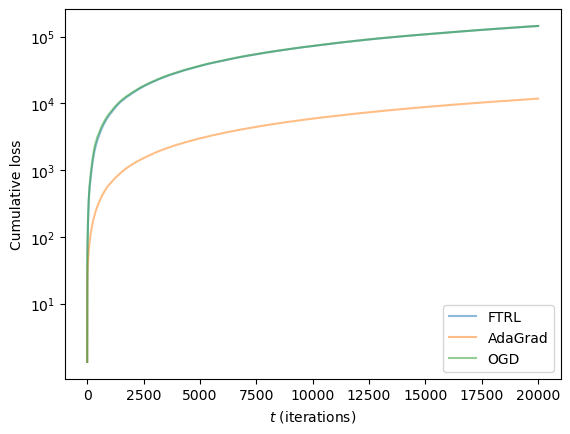

In [25]:
# Plot obtained cost at each round
plot_regret([Cost_ftrl, Cost_AdaGrad, Cost_ogd], 
            ['FTRL', 'AdaGrad', 'OGD'])
#plt.yscale('symlog')

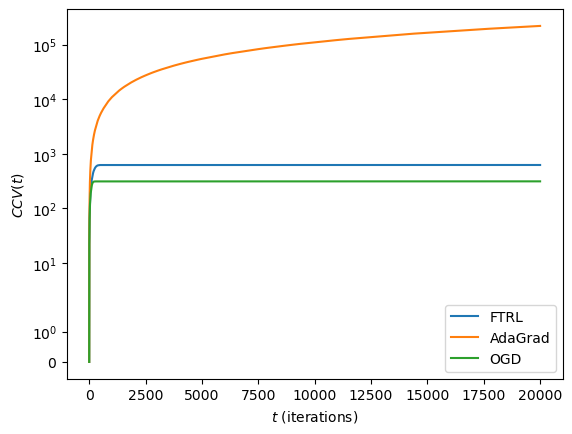

In [26]:
# Plot obtained CCV
plot_ccv([CCV_ftrl, CCV_AdaGrad, CCV_ogd], 
         ['FTRL', 'AdaGrad', 'OGD'])

# Run Multiple Experiments

In [28]:
S = 100    # Run 100 trials

n = 10
k = 4
T = 5000

# Assumptions parameters
D = np.sqrt(2)
F = n**2
G = np.sqrt(4 * n)
assumptions_param = (F, G, D)

Cost_dict = {'FTRL': [], 'AdaGrad': [], 'OGD': []}
CCV_dict = {'FTRL': [], 'AdaGrad': [], 'OGD': []}


for _ in tqdm(range(S)):
    dataset = new_dataset(n, k, T)

    #Initial guess
    x_0 = np.random.uniform(0.0, 1.0, size=n).reshape(-1,1)

    # Run Follow-the-Regularized-Leader
    FTRL_alg = adv_FTRL(x_0, T, assumptions_param)
    _, Preds = FTRL_alg.run(dataset)
    
    Cost_ftrl, CCV_ftrl = compute_cost_and_ccv(dataset, Preds)
    Cost_dict['FTRL'].append(Cost_ftrl)
    CCV_dict['FTRL'].append(CCV_ftrl)
    
    # Run AdaGrad
    AdaGrad_alg = adv_AdaGrad(x_0, T, assumptions_param)
    _, Preds = AdaGrad_alg.run(dataset)
    
    Cost_AdaGrad, CCV_AdaGrad = compute_cost_and_ccv(dataset, Preds)
    Cost_dict['AdaGrad'].append(Cost_AdaGrad)
    CCV_dict['AdaGrad'].append(CCV_AdaGrad)
    
    # Run Online Gradient Descent
    OGD_alg = adv_OGD(x_0, T, assumptions_param)
    _, Preds = OGD_alg.run(dataset)
    
    Cost_OGD, CCV_OGD = compute_cost_and_ccv(dataset, Preds)
    Cost_dict['OGD'].append(Cost_OGD)
    CCV_dict['OGD'].append(CCV_OGD)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [39:27<00:00, 23.67s/it]


In [29]:
SIZE = 12
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-1)    # legend fontsize

In [30]:
Cost_dict['FTRL'] = np.array(Cost_dict['FTRL'])
CCV_dict['FTRL'] = np.array(CCV_dict['FTRL'])

Cost_dict['AdaGrad'] = np.array(Cost_dict['AdaGrad'])
CCV_dict['AdaGrad'] = np.array(CCV_dict['AdaGrad'])

Cost_dict['OGD'] = np.array(Cost_dict['OGD'])
CCV_dict['OGD'] = np.array(CCV_dict['OGD'])

In [31]:
mean_cost_ftrl = np.mean(Cost_dict['FTRL'], axis=0)
std_cost_ftrl = 2 * np.std(Cost_dict['FTRL'], axis=0)

mean_cost_AdaGrad = np.mean(Cost_dict['AdaGrad'], axis=0)
std_cost_AdaGrad = 2 * np.std(Cost_dict['AdaGrad'], axis=0)

mean_cost_ogd = np.mean(Cost_dict['OGD'], axis=0)
std_cost_ogd = 2 * np.std(Cost_dict['OGD'], axis=0)

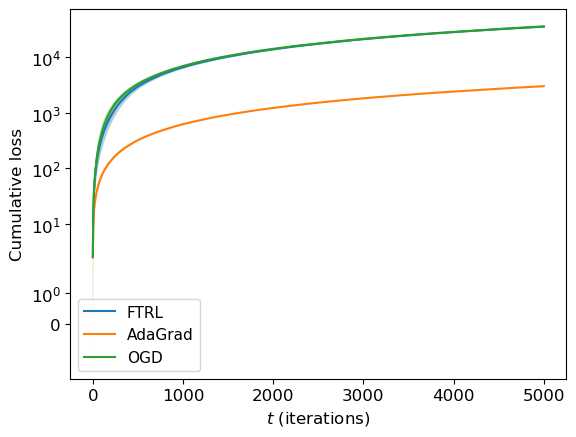

In [32]:
ts = np.linspace(1,T,T)
plt.plot(ts, mean_cost_ftrl, label='FTRL')
plt.fill_between(ts, mean_cost_ftrl-std_cost_ftrl, mean_cost_ftrl+std_cost_ftrl, alpha=0.35)

plt.plot(ts, mean_cost_AdaGrad, label='AdaGrad')
plt.fill_between(ts, mean_cost_AdaGrad-std_cost_AdaGrad, mean_cost_AdaGrad+std_cost_AdaGrad, alpha=0.35)

plt.plot(ts, mean_cost_ogd, label='OGD')
plt.fill_between(ts, mean_cost_ogd-std_cost_ogd, mean_cost_ogd+std_cost_ogd, alpha=0.35)

plt.ylabel('Cumulative loss')
plt.xlabel('$t$ (iterations)')
plt.yscale('symlog')

plt.legend()
plt.savefig('Cost_regression.pdf', format='pdf', bbox_inches='tight')

In [33]:
mean_ccv_ftrl = np.mean(CCV_dict['FTRL'], axis=0)
std_ccv_ftrl = 2 * np.std(CCV_dict['FTRL'], axis=0)

mean_ccv_AdaGrad = np.mean(CCV_dict['AdaGrad'], axis=0)
std_ccv_AdaGrad = 2 * np.std(CCV_dict['AdaGrad'], axis=0)

mean_ccv_ogd = np.mean(CCV_dict['OGD'], axis=0)
std_ccv_ogd = 2 * np.std(CCV_dict['OGD'], axis=0)

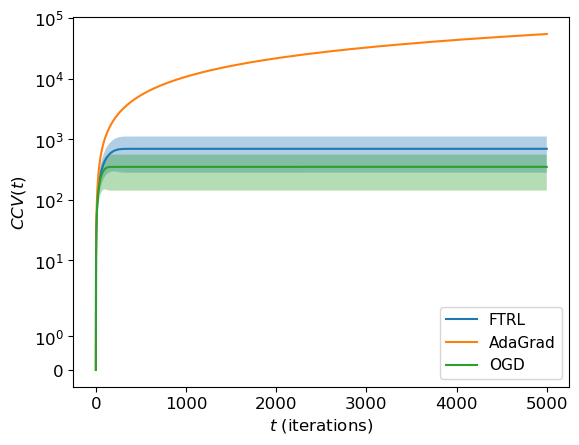

In [34]:
ts = np.linspace(0,T,T+1)
plt.plot(ts, mean_ccv_ftrl, label='FTRL')
plt.fill_between(ts, mean_ccv_ftrl-std_ccv_ftrl, mean_ccv_ftrl+std_ccv_ftrl, alpha=0.35)

plt.plot(ts, mean_ccv_AdaGrad, label='AdaGrad')
plt.fill_between(ts, mean_ccv_AdaGrad-std_ccv_AdaGrad, mean_ccv_AdaGrad+std_ccv_AdaGrad, alpha=0.35)

plt.plot(ts, mean_ccv_ogd, label='OGD')
plt.fill_between(ts, mean_ccv_ogd-std_ccv_ogd, mean_ccv_ogd+std_ccv_ogd, alpha=0.35)

plt.yscale('symlog')
plt.ylabel('$CCV(t)$')
plt.xlabel('$t$ (iterations)')
plt.legend()

plt.savefig('CCV_regression.pdf', format='pdf', bbox_inches='tight')